# MIBC multiclass classifier 

_____________________________________________________________________________________________________________________________________________

### 1- Data wrangling

The data set that Iused for this job is coming from Sjödahl et.al J Pathol 2017; 242: 113–125. 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os as os 

In [3]:
from google.colab import files
uploaded = files.upload()

Saving JPATH_MIBC_24Markers_Scaled_193.csv to JPATH_MIBC_24Markers_Scaled_193.csv


In [4]:
# store data into a variable
data = pd.read_csv("JPATH_MIBC_24Markers_Scaled_193.csv")
data.head()

,IHC.subtype,GATA3_norm,CK5_norm,p16_norm,CCNB1_norm,CCND1_norm,CDH1_norm,CDH3_norm,CHGA_norm,E2F3_norm,EPCAM_norm,FGFR3_norm,FOXA1_norm,KRT14_norm,KRT20_norm,NCAM1_norm,PPARG_norm,RB1_norm,RXRA_norm,SYP_norm,TP63_norm,TUBB2B_norm,UPK3_norm,VIM_norm,ZEB2_norm
0,BaSq,0.055556,1.000000,0.333333,0.555556,1.000000,0.833333,1.000000,0.0,0.185185,0.444444,0.666667,0.333333,1.000000,0.0,0.000000,0.000000,1.0,0.296296,0.0,1.000000,0.740741,0.0,0.500000,0.000000
1,BaSq,0.314815,1.000000,1.000000,0.555556,0.000000,0.666667,0.592593,0.0,0.203704,0.555556,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.185185,0.0,1.000000,0.370370,0.0,0.000000,0.333333
2,BaSq,0.000000,1.000000,0.500000,0.388889,0.000000,1.000000,1.000000,0.0,0.277778,0.203704,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.185185,0.0,0.018519,0.000000
3,Uro,0.833333,0.444444,0.166667,0.166667,0.888889,1.000000,0.666667,0.0,0.092593,0.574074,0.333333,1.000000,0.018519,0.0,0.000000,0.592593,1.0,0.259259,0.0,0.888889,0.000000,0.0,0.111111,0.000000
4,BaSq,0.222222,0.833333,0.333333,0.444444,0.481481,0.666667,0.833333,0.0,0.092593,0.888889,0.000000,0.166667,1.000000,0.0,0.018519,0.000000,1.0,0.000000,0.0,1.000000,0.185185,0.0,0.259259,0.000000


In [6]:
#data.columns

data.columns = ['Subtype_IHC', 'GATA3', 'CK5', 'p16', 'CCNB1','CCND1', 'CDH1', 'CDH3', 'CHGA', 'E2F3','EPCAM',
 'FGFR3', 'FOXA1', 'KRT14', 'KRT20','NCAM1', 'PPARG', 'RB1', 'RXRA', 'SYP','TP63', 'TUBB2B', 'UPK3',
 'VIM', 'ZEB2']
#data.head()

In [8]:
print(data.shape)

(193, 25)


In [9]:
# slicing based on columns
d = data.iloc[:, 1:25]

# imputing missing values by mean of columns
d.fillna(d.mean(), inplace = True)

#print(d.isnull().sum())
d.head()

,GATA3,CK5,p16,CCNB1,CCND1,CDH1,CDH3,CHGA,E2F3,EPCAM,FGFR3,FOXA1,KRT14,KRT20,NCAM1,PPARG,RB1,RXRA,SYP,TP63,TUBB2B,UPK3,VIM,ZEB2
0,0.055556,1.000000,0.333333,0.555556,1.000000,0.833333,1.000000,0.0,0.185185,0.444444,0.666667,0.333333,1.000000,0.0,0.000000,0.000000,1.0,0.296296,0.0,1.000000,0.740741,0.0,0.500000,0.000000
1,0.314815,1.000000,1.000000,0.555556,0.000000,0.666667,0.592593,0.0,0.203704,0.555556,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.185185,0.0,1.000000,0.370370,0.0,0.000000,0.333333
2,0.000000,1.000000,0.500000,0.388889,0.000000,1.000000,1.000000,0.0,0.277778,0.203704,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.185185,0.0,0.018519,0.000000
3,0.833333,0.444444,0.166667,0.166667,0.888889,1.000000,0.666667,0.0,0.092593,0.574074,0.333333,1.000000,0.018519,0.0,0.000000,0.592593,1.0,0.259259,0.0,0.888889,0.000000,0.0,0.111111,0.000000
4,0.222222,0.833333,0.333333,0.444444,0.481481,0.666667,0.833333,0.0,0.092593,0.888889,0.000000,0.166667,1.000000,0.0,0.018519,0.000000,1.0,0.000000,0.0,1.000000,0.185185,0.0,0.259259,0.000000


In [10]:
# replace a part of data farme by othe dataframe

data = pd.concat([data.iloc[:, 0], d], axis=1)

#print(data.isnull().sum())

In [11]:
# drop values from subtype_IHC column
data = data.drop(data[(data['Subtype_IHC'] == 'Mes-L') | (data['Subtype_IHC'] == 'Sc/NE')].index)
print(data.Subtype_IHC.value_counts())


Uro     82
GU      54
BaSq    41
Name: Subtype_IHC, dtype: int64


In [12]:
data.columns

Index(['Subtype_IHC', 'GATA3', 'CK5', 'p16', 'CCNB1', 'CCND1', 'CDH1', 'CDH3',
       'CHGA', 'E2F3', 'EPCAM', 'FGFR3', 'FOXA1', 'KRT14', 'KRT20', 'NCAM1',
       'PPARG', 'RB1', 'RXRA', 'SYP', 'TP63', 'TUBB2B', 'UPK3', 'VIM', 'ZEB2'],
      dtype='object')

In [13]:
# feature selection based on ROC analysis:
## KRT14, KRT5, CDH3, FOXA1, GATA3, PPARG, EPCAM for Uro vs. Bas [AUC > 80%]
## RB1 , CCND1, p16, TP63 for Uro vs. Gu [AUC > 80%]
## CK5, KRT14, CDH3, FOXA1, GATA3, EPCAM, TP63 ,PPARG for GU vs. Bas [AUC > 80%]


_____________________________________________________________________________________________________________________________________________

### 2-Making decision tree classifier

In [14]:
X = data[["KRT14", "CK5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "p16", "EPCAM", "TP63"]].values
y = data.iloc[:,0].values
# codes; 0 = BaSq, 1 = Uro, 2 = GU

In [15]:
# encode IHC subtype as a dummy variable
y,class_names = pd.factorize(y)

X.shape[0]

177

In [17]:
#Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

**Finding optimum tree depth by cross validation**


**Stratified k-fold cross validation**

StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.



In [18]:
# using cv to find depth:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold,StratifiedKFold

crossvalidation = KFold(n_splits=10, shuffle=True, random_state= 42) # I dont use this 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # suitable for multiclass and unblanced classification groups

In [29]:
from sklearn import tree
for depth in range(1,10):
 tree_classifier = tree.DecisionTreeClassifier(
  max_depth=depth, random_state=42)
 if tree_classifier.fit(X,y).tree_.max_depth < depth:
  break
 score = np.mean(cross_val_score(tree_classifier, X, y,scoring='accuracy', cv=skf, n_jobs=1))
 print ('Depth: %i Accuracy: %.3f' %(depth,score))

Depth: 1 Accuracy: 0.706
Depth: 2 Accuracy: 0.836
Depth: 3 Accuracy: 0.830
Depth: 4 Accuracy: 0.858
Depth: 5 Accuracy: 0.836
Depth: 6 Accuracy: 0.836
Depth: 7 Accuracy: 0.842
Depth: 8 Accuracy: 0.853
Depth: 9 Accuracy: 0.853


**Training model by CV**

In [21]:
# this should be leave one out method! 
from scipy.stats import sem
from sklearn import metrics
clf = tree.DecisionTreeClassifier(criterion= 'entropy', min_samples_split=2, min_samples_leaf=2,random_state=42, max_depth=4)


def skf_cv(X_train,y_train,clf):
    # Perform stratified cross validation
    scores=np.zeros(X_train[:].shape[0])
    for train_index,test_index in skf.split(X_train,y_train):
        X_train_cv, X_test_cv, y_train_cv, y_test_cv = X[train_index], X[test_index], y[train_index], y[test_index]
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred=clf.predict(X_test_cv)
        scores[test_index]=metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores)))

In [22]:
skf_cv(X_train, y_train,clf)

Mean score: 0.856 (+/-0.007)


In [33]:
# defining a helper function
def get_score(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [34]:
tree_classifier = tree.DecisionTreeClassifier(criterion= 'entropy',random_state=42, max_depth=4)

scores_tree = []
#fscore_tree = []

for train_index, test_index in skf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
  print(get_score(tree_classifier, X_train_cv, X_test_cv, y_train_cv, y_test_cv))
  scores_tree.append(get_score(tree_classifier, X_train_cv, X_test_cv, y_train_cv, y_test_cv))


0.8571428571428571
0.8571428571428571
0.9230769230769231
0.8461538461538461
1.0
0.8461538461538461
0.8461538461538461
0.9230769230769231
0.7692307692307693
0.6153846153846154


In [37]:
# instead of writing the above code we can use cross_val_score to get score that we want from cross validation job
from scipy.stats import sem
cv_score = cross_val_score(tree_classifier, X_train, y_train, cv=skf)

print (("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(cv_score), sem(cv_score)))

Mean score: 0.848 (+/-0.032)


### Classifier prediction on the test set


In [26]:
y_pred=tree_classifier.predict(X_test)

# Classification results on test set
print('Classification results on test set')
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred))

Classification results on test set
Accuracy: 0.82
Confusion Matrix: 
 [[ 8  2  0]
 [ 1 20  0]
 [ 1  4  9]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.77      0.95      0.85        21
           2       1.00      0.64      0.78        14

    accuracy                           0.82        45
   macro avg       0.86      0.80      0.81        45
weighted avg       0.85      0.82      0.82        45



_____________________________________________________________________________________________________________________________________________

### 5-Visualization

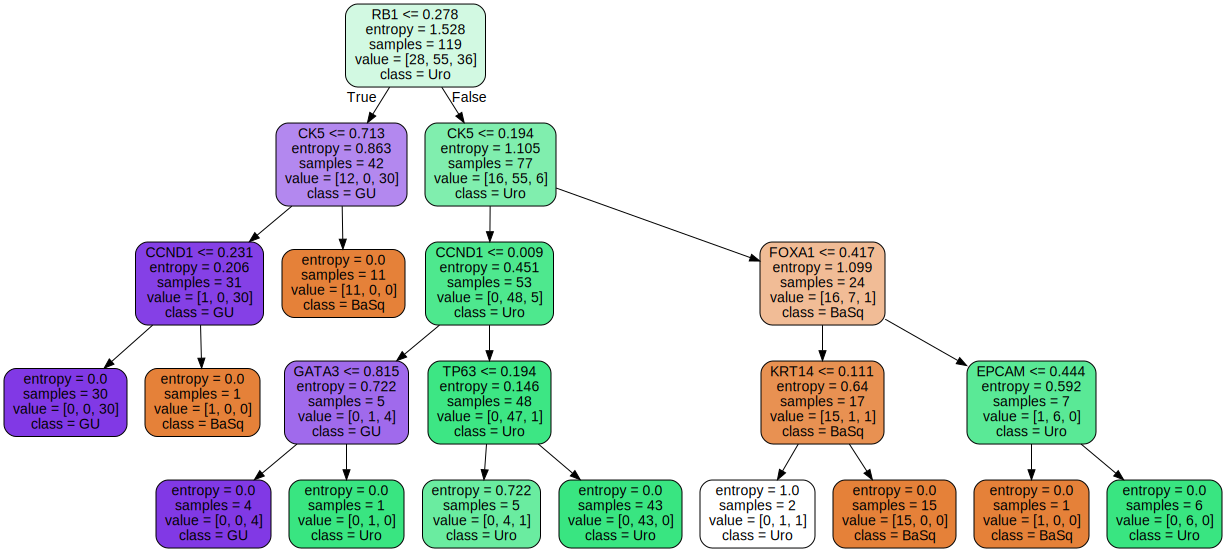

In [27]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
from IPython.display import Image
from IPython.display import Image 
import matplotlib.pyplot as plt 

feature_names = ["KRT14", "CK5", "CDH3", "FOXA1", "GATA3", "PPARG", "RB1" , "CCND1", "p16", "EPCAM", "TP63"]
dot_data = tree.export_graphviz(tree_classifier, out_file=None, filled=True,feature_names = feature_names, rounded = True, class_names=class_names)
graph = graphviz.Source(dot_data)
graph
#graph.render('tree.png', view=True)  
#graph.write_png('my_decision_tree.png')
#files.download('tree.png')